In [147]:
%load_ext autoreload
%autoreload 1
%aimport src.utils

import os
import urllib.request

from matplotlib import pyplot as plt
import numpy as np
import scipy.io as sio
import torch
import torch.nn.functional as F
from tqdm import tqdm

from src import utils  # our utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


data exists; not downloading


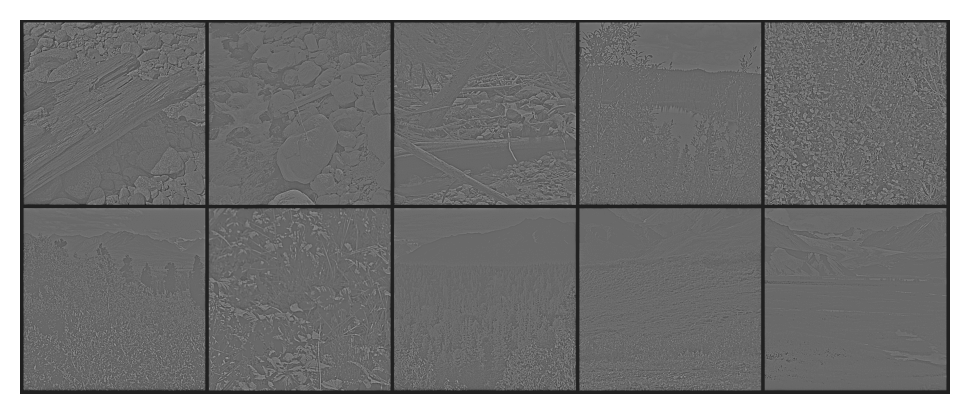

In [163]:
# Download data (20MB) to specified directory.
img_path = "IMAGES.mat"
utils.maybe_download_data(img_path)

In [149]:
# Init variables.
num_bases = 64
basis_size = 64
rng = np.random.defaultb_rng(seed=0)  # TODO remove
torch.manual_seed(0)
patch_size = 8 # 8x8 image # 16x16 in paper

# Tunable parameters.
epochs = 4000
num_infer_iters = 1000
batch_size = 100
lambd_div_sigma = 0.5 # Figure 4 description.
a_lr = 1e-3
phi_lr = 1e-3
epsilon = 0.001

# Sparse nonlinearity; we use |x|, but there are other options.
S = lambda x: torch.abs(x)  # Appears in equation 4.
S_prime = lambda x: torch.sign(x)  # Appears in equation 5.

# Nonlinear function and its derivative.
# Cauchy - can't get this to work
# S = lambda x: torch.log(1 + x**2)
# S_prime = lambda x: (2*x)/(x**2 + 1)

# Other thing in the paper
# S = lambda x: -torch.exp(-torch.square(x))
# S_prime = lambda x: 2*x*torch.exp(-torch.square(x))

# For display purposes.
def loss_fn(I, Ihat, a, sigma):
    mse = F.mse_loss(Ihat, I).data  # Equation 3.
    sparseness = torch.sum(S(a/sigma))  # Equation 4.
    return mse, sparseness # Equation 2.

# Initialize dict and visualize.
phi = torch.randn(basis_size, num_bases)  # Standard normal.
phi = F.normalize(phi, dim=0)  # Normalize each basis to unit length.

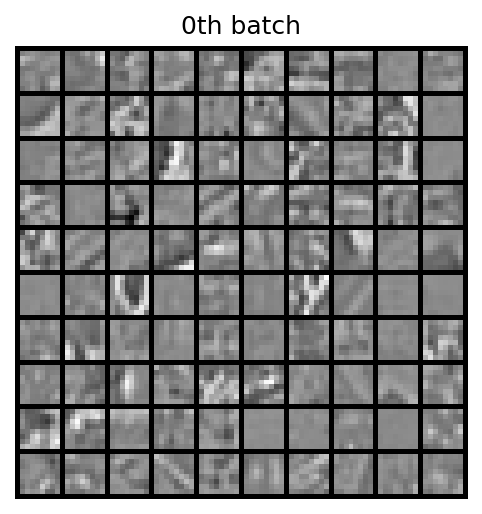

In [150]:
# pre compute batches (slowest part)
# patches = torch.zeros((epochs, batch_size, basis_size))
# for i in range(epochs):
#     patches[i, :,: ] = torch.Tensor(utils.extract_patches(imgs, patch_size, batch_size, rng))  # (batch_size, basis_size)
# torch.save(patches, "patches_5k")

# load batches
patches = torch.load("../vanilla_sc_old/patches_5k")
utils.visualize_patches(patches[0,:,:], "0th batch")

In [151]:
# Initialize lists to store losses for plotting later.
total_losses = []
mses = []
sparse_losses = []
prev_loss = torch.inf  # Initialize this for inference early stopping condition.

for i in tqdm(range(epochs)):
    I = patches[i, :, :] 
    sigma = torch.sqrt(torch.var(I))  # Figure 4 description.
    lambd = lambd_div_sigma * sigma  # Not used in optimization.
    
    # Inner loop uses Euler's method to infer coefficients a.
    a = torch.zeros(batch_size, num_bases)
    for j in range(num_infer_iters):
        b = torch.mm(I, phi)
        C = torch.mm(phi.T, phi) - torch.eye(num_bases)

        # Obtain gradient based on Equation 5.
        da = b - torch.mm(C, a.T).T - ((lambd_div_sigma) * S_prime(a/sigma))
        a += a_lr * da 

        # Decide whether to stop early based on change in loss.
        mse, sparseness = loss_fn(I, Ihat, a, sigma)
        loss = -(-mse - lambd * sparseness) / batch_size  # Equation 2.
        if torch.abs(loss - prev_loss) < epsilon * prev_loss:
            break
        prev_loss = loss

    # Update dictionary.
    Ihat = torch.mm(phi, a.T).T
    dphi = torch.mm((I - Ihat).T, a)  # Equation 6.
    phi += phi_lr * dphi

    # Normalize each basis to unit length.
    phi = F.normalize(phi, dim=0)

    # Calculate loss for display purposes.
    mse, sparseness = loss_fn(I, Ihat, a, sigma)
    total = -(-mse - lambd * sparseness) / batch_size # Equation 2.
    total_losses.append(total)
    mses.append(mse)
    sparse_losses.append(sparseness)
print("final total: {}, mse: {}, sparse: {}".format(total, mse, sparseness))

100%|██████████| 4000/4000 [15:49<00:00,  4.21it/s]

final total: 7.7784271240234375, mse: 0.14092618227005005, sparse: 1498.5574951171875


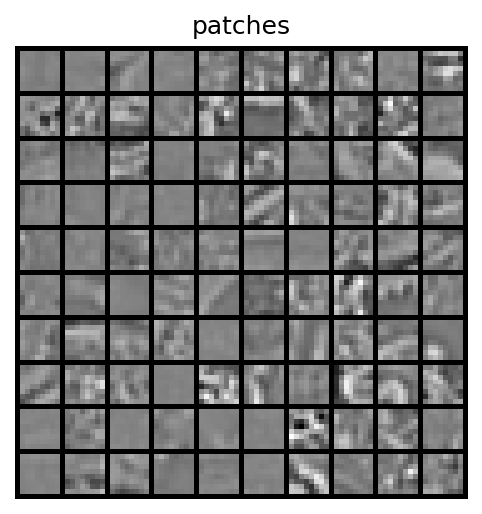

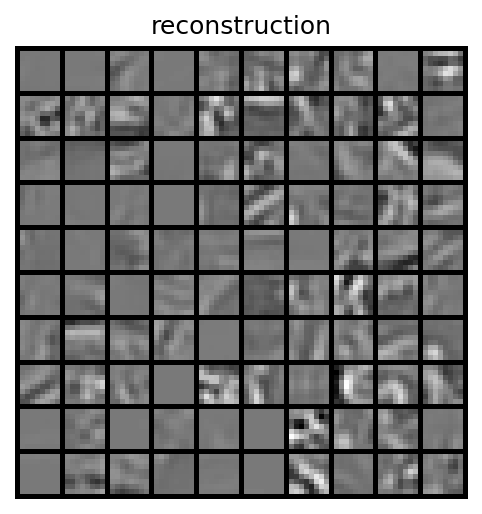

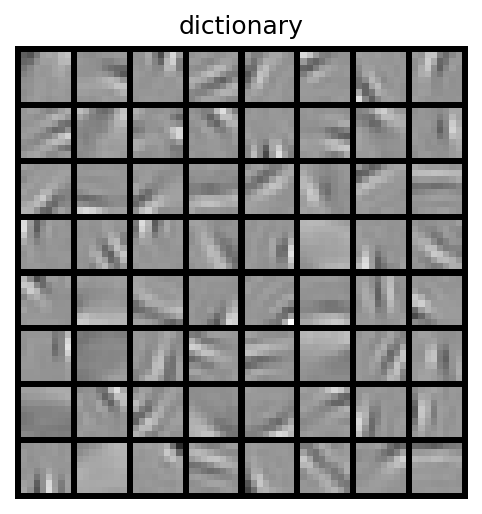

In [157]:
# Visualize the last batch's original images, reconstruction, and the learned dictionary.
utils.visualize_patches(I, "patches")
utils.visualize_patches(Ihat, "reconstruction")
utils.visualize_bases(phi, "dictionary")

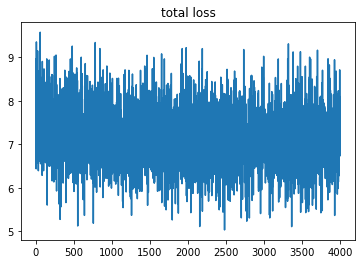

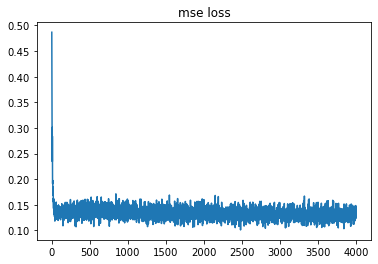

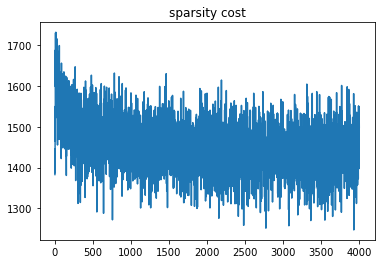

In [156]:
# Plot losses.
utils.plot_line(total_losses, "total loss")
utils.plot_line(mses, "mse loss")
utils.plot_line(sparse_losses, "sparsity cost")

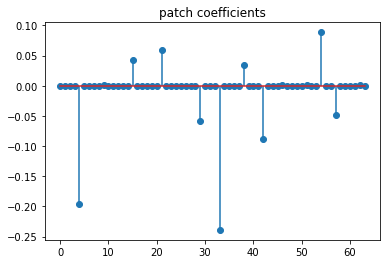

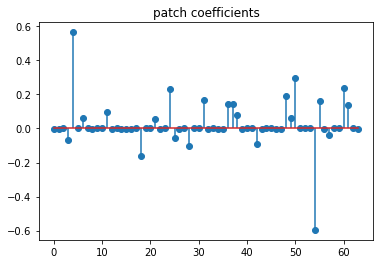

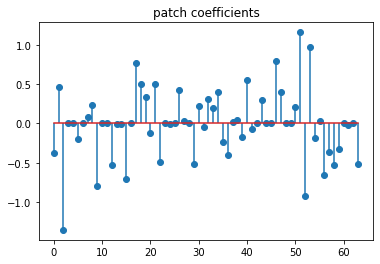

In [161]:
# Visualize the 0th, 50th, and 99th patch coefficients.
utils.plot_coeffs(a[0])
utils.plot_coeffs(a[50])
utils.plot_coeffs(a[99])